In [ ]:
#Always start with a clean session
rm(list = ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1636505,87.4,3958798,211.5,3958798,211.5
Vcells,4003852,30.6,143260540,1093.0,123921096,945.5


In [ ]:
install.packages("igraph")
library(igraph)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#Part 1: Building the Network

In [ ]:
#Load data
emails <- read.csv("/content/emails.csv", stringsAsFactors = FALSE)
head(emails$message)

[1] "Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
[2] "Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"
[3] "Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>\nDate: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: leah.arsdall@enron.com\nSubject: Re: test\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Leah Van Arsdall\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\ntest successful.  way to go!!!"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
[4] "Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>\nDate: Mon, 23 O

In [ ]:
#Formatting
library(tidyverse)

#Extract To and From fields to create edges (from raw email headers)
edges <- emails %>%
  mutate(
    from = str_extract(message, "(?<=From: )[^\n]+"),
    to = str_extract(message, "(?<=To: )[^\n]+")
  ) %>%
  filter(!is.na(from), !is.na(to))

In [ ]:
#Formatting cont.
edges_expanded <- edges %>%
  select(from, to) %>%
  mutate(to = str_split(to, ",|;")) %>%   #Split on comma
  unnest(to) %>%                          #Explode onto multiple rows
  mutate(
    from = str_trim(from),
    to   = str_trim(to)
  ) %>%
  filter(to != "", from != "") %>%
  #Make the edge list deterministic
  #guarantees the same edges in the same order every run
  arrange(from, to) %>%  #Sorting in dictionary order (lexicographically)
  distinct()

head(edges_expanded)

from,to
<chr>,<chr>
'todd'.delahoussaye@enron.com,derek.bailey@enron.com
'todd'.delahoussaye@enron.com,jean.bell@enron.com
'todd'.delahoussaye@enron.com,randy.bhatia@enron.com
'todd'.delahoussaye@enron.com,susan.bailey@enron.com
--migrated--bmishkin@ercot.com,mockmarket@ercot.com
--migrated--dodle@ercot.com,set@ercot.com


Example of dictionary order:

alice@enron.com

allen-p/_sent_mail/1.

allen-p/_sent_mail/10.

allen-p/_sent_mail/100.

bob@enron.com

carol@enron.com

In [ ]:
#Create directed graph

edge_matrix <- as.matrix(edges_expanded)
head(edge_matrix)

g = graph_from_edgelist(edge_matrix, directed = TRUE)

from,to
'todd'.delahoussaye@enron.com,derek.bailey@enron.com
'todd'.delahoussaye@enron.com,jean.bell@enron.com
'todd'.delahoussaye@enron.com,randy.bhatia@enron.com
'todd'.delahoussaye@enron.com,susan.bailey@enron.com
--migrated--bmishkin@ercot.com,mockmarket@ercot.com
--migrated--dodle@ercot.com,set@ercot.com


#Part 2: Troubleshooting
For finding deterministic edges to create our graph so centrality measurements do not change.

In [ ]:
#Check to see if our edges_expanded actually produces the same output everytime.
#They in fact do not. This would be our problem for sure
nrow(edges_expanded)
nrow(distinct(edges_expanded))
nrow(emails)
# Extra: snapshot check
summary(edges_expanded$from)
summary(edges_expanded$to)

#previous output was 117879 for each.

[1] 117879

[1] 117879

[1] 517401

   Length     Class      Mode 
   117879 character character 

   Length     Class      Mode 
   117879 character character 

In [ ]:
#Number of nodes & number of edges
head(V(g))
head(E(g))
vcount(g)
ecount(g)
is_directed(g)


+ 6/45650 vertices, named, from fbb1b48:
[1] 'todd'.delahoussaye@enron.com  derek.bailey@enron.com        
[3] jean.bell@enron.com            randy.bhatia@enron.com        
[5] susan.bailey@enron.com         --migrated--bmishkin@ercot.com

+ 6/117879 edges from fbb1b48 (vertex names):
[1] 'todd'.delahoussaye@enron.com ->derek.bailey@enron.com
[2] 'todd'.delahoussaye@enron.com ->jean.bell@enron.com   
[3] 'todd'.delahoussaye@enron.com ->randy.bhatia@enron.com
[4] 'todd'.delahoussaye@enron.com ->susan.bailey@enron.com
[5] --migrated--bmishkin@ercot.com->mockmarket@ercot.com  
[6] --migrated--dodle@ercot.com   ->set@ercot.com         

[1] 45650

[1] 117879

[1] TRUE

#Centrality Analysis

In [ ]:
#Degree Centrality
deg_in  <- degree(g, mode = "in", loops=FALSE)
deg_out <- degree(g, mode = "out", loops=FALSE)

In [ ]:
#LCC
g_undir <- as_undirected(g, mode = "collapse")
comp <- components(g_undir)
largest <- which.max(comp$csize)
g_lcc <- induced_subgraph(g_undir, comp$membership == largest)

In [ ]:
#adding total degree centrality for undirected, lcc to compare with eig centrality results
deg_total <- degree(g_lcc)

In [ ]:
#How much smaller is our LCC?

vcount(g_lcc)

#Looks like our second largest component is 2833 nodes and there are 1563 components of our network total
component_info <- components(g)


[1] 41970

In [ ]:
#Eigen and Betweenness

closeness_centrality <- closeness(g_lcc, normalized = TRUE)
eig <- eigen_centrality(g_lcc, directed = FALSE)
eigen_centrality <- eig$vector
betweenness_centrality <- betweenness(g_undir, directed = FALSE, normalized = TRUE)


In [ ]:
#Centrality Dataframe
centrality_df <- tibble(
  node       = names(deg_in),
  totaldegree = as.numeric(deg_total[names(deg_in)]),
  indegree   = as.numeric(deg_in),
  outdegree  = as.numeric(deg_out),
  closeness  = as.numeric(closeness_centrality[names(deg_in)]),
  eigen      = as.numeric(eigen_centrality[names(deg_in)]),
  betweenness = as.numeric(betweenness_centrality[names(deg_in)])
)

centrality_df

node,totaldegree,indegree,outdegree,closeness,eigen,betweenness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
'todd'.delahoussaye@enron.com,5,1,4,0.2369176,6.984955e-03,1.386460e-06
derek.bailey@enron.com,25,22,6,0.2630230,5.717594e-02,8.248806e-05
jean.bell@enron.com,10,9,2,0.2530311,2.617778e-02,1.089814e-04
randy.bhatia@enron.com,26,18,17,0.2545612,2.495643e-02,6.413945e-05
susan.bailey@enron.com,188,134,116,0.2898472,2.769411e-01,4.629395e-03
--migrated--bmishkin@ercot.com,1,0,1,0.1070758,2.622820e-12,0.000000e+00
mockmarket@ercot.com,4,4,0,0.1199155,1.929422e-10,7.562543e-05
--migrated--dodle@ercot.com,3,2,1,0.2078785,6.606161e-04,6.894967e-05
set@ercot.com,28,28,0,0.2102697,6.941265e-04,1.080989e-03


#Part 3: Finding Top 10 for Each Centrality Measure


In [ ]:
#Top k Ranking
colnames(centrality_df)

topk <- 10

#added undirected degree centrality
top_total <- centrality_df %>%
  arrange(desc(totaldegree)) %>%
  slice_head(n = topk) %>%
  select(node, totaldegree)

top_in <- centrality_df %>%
  arrange(desc(indegree)) %>%
  slice_head(n = topk) %>%
  select(node, indegree)

top_out <- centrality_df %>%
  arrange(desc(outdegree)) %>%
  slice_head(n = topk) %>%
  select(node, outdegree)

top_close <- centrality_df %>%
  arrange(desc(closeness)) %>%
  slice_head(n = topk) %>%
  select(node, closeness)

top_eigen <- centrality_df %>%
  arrange(desc(eigen)) %>%
  slice_head(n = topk) %>%
  select(node, eigen)

top_between <- centrality_df %>%
  arrange(desc(betweenness)) %>%
  slice_head(n = topk) %>%
  select(node, betweenness)

top_total
top_in
top_out
top_close
top_eigen
top_between

[1] "node"        "totaldegree" "indegree"    "outdegree"   "closeness"  
[6] "eigen"       "betweenness"

node,totaldegree
<chr>,<dbl>
klay@enron.com,1296
tana.jones@enron.com,929
sara.shackleton@enron.com,924
jeff.dasovich@enron.com,915
vince.kaminski@enron.com,837
kenneth.lay@enron.com,706
gerald.nemec@enron.com,699
louise.kitchen@enron.com,692
sally.beck@enron.com,688


node,indegree
<chr>,<dbl>
klay@enron.com,1296
kenneth.lay@enron.com,691
jeff.skilling@enron.com,661
sara.shackleton@enron.com,603
tana.jones@enron.com,571
jeff.dasovich@enron.com,570
louise.kitchen@enron.com,559
sally.beck@enron.com,483
gerald.nemec@enron.com,454


node,outdegree
<chr>,<dbl>
vince.kaminski@enron.com,750
tana.jones@enron.com,746
jeff.dasovich@enron.com,710
sara.shackleton@enron.com,701
kay.mann@enron.com,530
debra.perlingiere@enron.com,530
gerald.nemec@enron.com,511
chris.germany@enron.com,509
richard.sanders@enron.com,460


node,closeness
<chr>,<dbl>
perfmgmt@enron.com,0.3309989
louise.kitchen@enron.com,0.3302409
john.lavorato@enron.com,0.3226027
steven.kean@enron.com,0.3187438
jeff.dasovich@enron.com,0.3185648
sally.beck@enron.com,0.3171253
tim.belden@enron.com,0.3161221
greg.whalley@enron.com,0.3158675
exchange.administrator@enron.com,0.3151086


node,eigen
<chr>,<dbl>
louise.kitchen@enron.com,1.0000000
tana.jones@enron.com,0.8300316
john.lavorato@enron.com,0.7635619
sara.shackleton@enron.com,0.7618617
sally.beck@enron.com,0.7048061
mark.taylor@enron.com,0.7036613
elizabeth.sager@enron.com,0.6477471
steven.kean@enron.com,0.6193104
mark.haedicke@enron.com,0.5955426


node,betweenness
<chr>,<dbl>
jeff.dasovich@enron.com,0.05795217
klay@enron.com,0.05205220
perfmgmt@enron.com,0.04431399
gerald.nemec@enron.com,0.03701374
kenneth.lay@enron.com,0.03692517
jeff.skilling@enron.com,0.03438683
vince.kaminski@enron.com,0.02943059
sara.shackleton@enron.com,0.02812201
tana.jones@enron.com,0.02717557


#Part 4: Robustness Analysis

In [ ]:
library(igraph)
library(dplyr)
library(purrr)
library(tidyr)

largest_wcc_size <- function(graph){
  comps <- components(graph, mode = "weak")
  max(comps$csize)
}

num_wcc <- function(graph){
  components(graph, mode = "weak")$no
}

robustness_remove_topk <- function(g, centrality_df, metric_cols, ks = c(1,2,3)){

  #Baseline stats
  base_nodes <- vcount(g)
  base_edges <- ecount(g)
  base_lwcc  <- largest_wcc_size(g)
  base_ncomp <- num_wcc(g)

  results <- list()

  for(metric in metric_cols){

    ranked_nodes <- centrality_df %>%
      arrange(desc(.data[[metric]])) %>%
      pull(node) %>%
      na.omit() %>%
      as.character()

    for(k in ks){
      remove_nodes <- ranked_nodes[1:k]

      g_k <- delete_vertices(g, remove_nodes)

      lwcc_k <- largest_wcc_size(g_k)
      ncomp_k <- num_wcc(g_k)

      results[[length(results)+1]] <- tibble(
        metric = metric,
        k_removed = k,
        removed_nodes = paste(remove_nodes, collapse = ", "),
        nodes_left = vcount(g_k),
        edges_left = ecount(g_k),
        lwcc_size = lwcc_k,
        lwcc_frac = lwcc_k / base_lwcc,
        num_components = ncomp_k,
        delta_components = ncomp_k - base_ncomp,
        delta_lwcc = base_lwcc - lwcc_k
      )
    }
  }

  results_df <- bind_rows(results)

  baseline_df <- tibble(
    metric = metric_cols,
    k_removed = 0,
    removed_nodes = "",
    nodes_left = base_nodes,
    edges_left = base_edges,
    lwcc_size = base_lwcc,
    lwcc_frac = 1,
    num_components = base_ncomp,
    delta_components = 0,
    delta_lwcc = 0
  )

  bind_rows(baseline_df, results_df) %>%
    arrange(metric, k_removed)
}


In [ ]:
#Run robustness analysis

metric_cols <- c("totaldegree", "indegree", "outdegree",
                 "closeness", "eigen", "betweenness")

robustness_results <- robustness_remove_topk(g, centrality_df, metric_cols)

robustness_results

metric,k_removed,removed_nodes,nodes_left,edges_left,lwcc_size,lwcc_frac,num_components,delta_components,delta_lwcc
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
betweenness,0,,45650,117879,41970,1.0000000,1563,0,0
betweenness,1,jeff.dasovich@enron.com,45649,116598,41730,0.9942816,1776,213,240
betweenness,2,"jeff.dasovich@enron.com, klay@enron.com",45648,115302,40480,0.9644985,3002,1439,1490
betweenness,3,"jeff.dasovich@enron.com, klay@enron.com, perfmgmt@enron.com",45647,115186,40463,0.9640934,3017,1454,1507
closeness,0,,45650,117879,41970,1.0000000,1563,0,0
closeness,1,perfmgmt@enron.com,45649,117761,41953,0.9995949,1578,15,17
closeness,2,"perfmgmt@enron.com, louise.kitchen@enron.com",45648,116847,41863,0.9974506,1667,104,107
closeness,3,"perfmgmt@enron.com, louise.kitchen@enron.com, john.lavorato@enron.com",45647,116214,41755,0.9948773,1753,190,215
eigen,0,,45650,117879,41970,1.0000000,1563,0,0


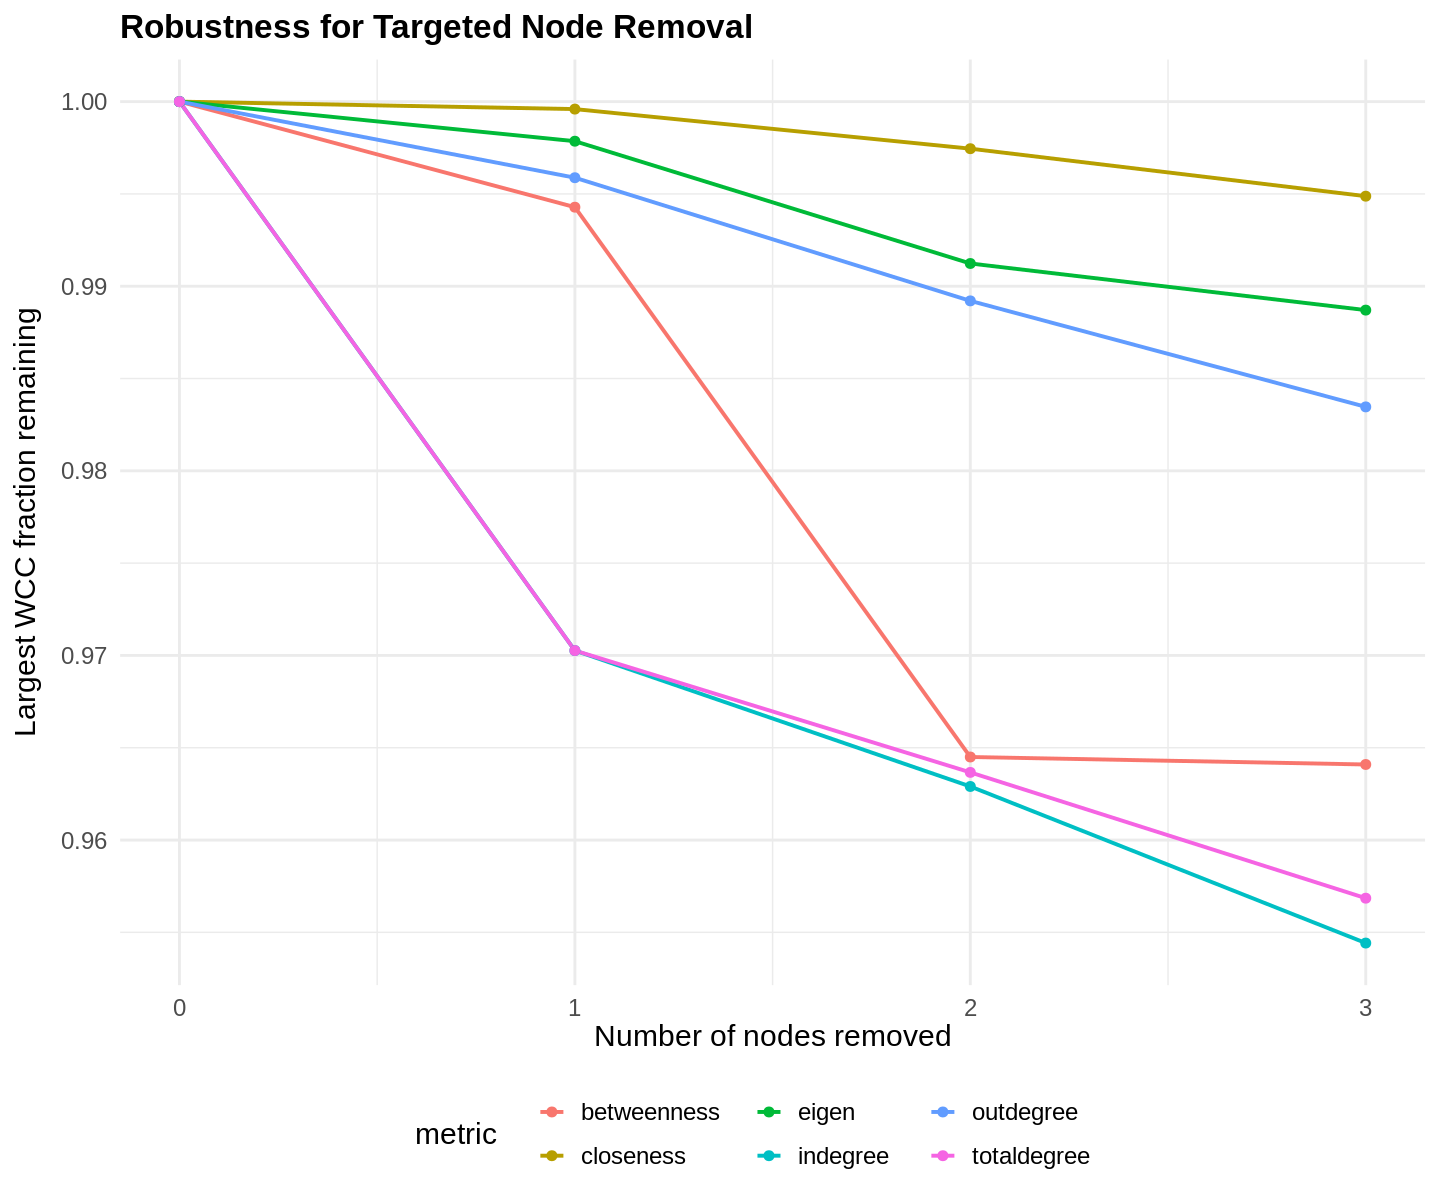

In [ ]:
#Plot of what happens to each centrality measure (LWCC fraction vs k removed)
library(ggplot2)

options(repr.plot.width = 12, repr.plot.height = 10)

ggplot(robustness_results, aes(x = k_removed, y = lwcc_frac, color = metric)) +
  geom_line(size = 1.1) +
  geom_point(size = 2) +
  scale_x_continuous(breaks = c(0,1,2,3)) +
  labs(
    title = "Robustness for Targeted Node Removal",
    x = "Number of nodes removed",
    y = "Largest WCC fraction remaining"
  )+
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_text(face = "bold", size = 20),
    legend.position = "bottom"
  )